<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/jose-eustasio-rivera/la-voragine/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' señor ministro: de acuerdo con los deseos de s. s. he arreglado para la publicidad los\r\nmanuscritos de arturo cova, remitidos a ese ministerio por el cónsul de\r\ncolombia en manaos. en esas páginas respeté el estilo y hasta las incorrecciones del\r\ninfortunado escritor, subrayando únicamente los provincialismos de más\r\ncarácter. creo, salvo mejor opinión de s. s., que este libro no se debe publicar\r\nantes de tener más noticias de los caucheros colombianos del río negro o\r\nguainía; pero si s. s. resolviere lo contrario, le ruego que se sirva\r\ncomunicarme oportunamente los datos que adquiera para adicionarlos a guisa\r\nde epílogo. soy de s. s. muy atento servidor, josé eustasio rivera. «...los que un tiempo creyeron que mi inteligencia irradiaría\nextraordinariamente, cual una aureola de mi juventud; los que se\nolvidaron de mí apenas mi planta descendió al infortunio; los que al\nrecordarme alguna vez piensen en mi fracaso y se pregunten por qué no fui\nlo que pude haber 

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

68

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [11]:
tokenized_text[:1000]

[15,
 60,
 1,
 29,
 5,
 58,
 15,
 38,
 45,
 23,
 45,
 60,
 20,
 58,
 5,
 47,
 15,
 14,
 1,
 15,
 67,
 9,
 24,
 1,
 58,
 14,
 5,
 15,
 9,
 5,
 23,
 15,
 0,
 5,
 60,
 15,
 14,
 1,
 60,
 1,
 5,
 60,
 15,
 14,
 1,
 15,
 60,
 39,
 15,
 60,
 39,
 15,
 32,
 1,
 15,
 67,
 58,
 58,
 1,
 25,
 0,
 67,
 14,
 5,
 15,
 64,
 67,
 58,
 67,
 15,
 0,
 67,
 15,
 64,
 24,
 3,
 0,
 45,
 9,
 45,
 14,
 67,
 14,
 15,
 0,
 5,
 60,
 2,
 55,
 38,
 67,
 23,
 24,
 60,
 9,
 58,
 45,
 20,
 5,
 60,
 15,
 14,
 1,
 15,
 67,
 58,
 20,
 24,
 58,
 5,
 15,
 9,
 5,
 19,
 67,
 10,
 15,
 58,
 1,
 38,
 45,
 20,
 45,
 14,
 5,
 60,
 15,
 67,
 15,
 1,
 60,
 1,
 15,
 38,
 45,
 23,
 45,
 60,
 20,
 1,
 58,
 45,
 5,
 15,
 64,
 5,
 58,
 15,
 1,
 0,
 15,
 9,
 42,
 23,
 60,
 24,
 0,
 15,
 14,
 1,
 2,
 55,
 9,
 5,
 0,
 5,
 38,
 3,
 45,
 67,
 15,
 1,
 23,
 15,
 38,
 67,
 23,
 67,
 5,
 60,
 39,
 15,
 1,
 23,
 15,
 1,
 60,
 67,
 60,
 15,
 64,
 11,
 25,
 45,
 23,
 67,
 60,
 15,
 58,
 1,
 60,
 64,
 1,
 20,
 4,
 15,
 1,
 0,
 15,
 1,
 60,
 20,


### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
X.shape

(439190, 100)

In [18]:
X[0,:10]

array([15, 60,  1, 29,  5, 58, 15, 38, 45, 23])

In [19]:
y[0,:10]

array([60,  1, 29,  5, 58, 15, 38, 45, 23, 45])

In [20]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [21]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

### SIMPLE RNN

In [22]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        53,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 68)       │        13,668 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,468 (263.55 KB)

 Trainable params: 67,468 (263.55 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [89]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5, name_model="my_model.keras"):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.history_ppl = history_ppl
      self.patience = patience
      self.name_model = name_model

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        print(self.name_model)
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.name_model)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [24]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=150)

Epoch 1/20
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3378
 mean perplexity: 6.952656861937756 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 72s 20ms/step - loss: 2.3377
Epoch 2/20
2925/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9505
 mean perplexity: 6.416671741669672 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.9505
Epoch 3/20
2925/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8870
 mean perplexity: 6.199407311680381 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.8870
Epoch 4/20
2924/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8591
 mean perplexity: 6.134964332933054 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.8591
Epoch 5/20
2924/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8431
 mean perplexity: 6.134769947621857 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.8431
Epoch 6/20
2924/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8319
 mean perp

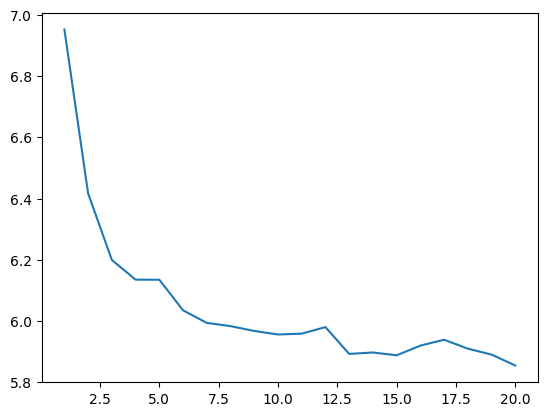

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [26]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

### Generación de secuencias

In [27]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [28]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'habia una vez de la cara de la cara de la c'

###  Beam search y muestreo aleatorio

In [29]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [41]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    print(temp)
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [66]:
# predicción con beam search
salidas = beam_search(model,num_beams=20,num_words=25,input="el aire caliente fulgia como", temp=0.5, mode="det")

0.5


In [68]:
salidas[0]

array([ 1,  0, 15, 67, 45, 58,  1, 15,  9, 67,  0, 45,  1, 23, 20,  1, 15,
        6, 24,  0, 25, 45, 67, 15,  9,  5, 38,  5, 15, 24, 23, 15, 32,  5,
       38,  3, 58,  1, 15, 14,  1, 15,  0, 67, 15,  9,  5, 58, 67, 63, 42,
       23, 15])

In [69]:
# veamos las salidas
for d in salidas:
  print(decode(d))




el aire caliente fulgia como un hombre de la corazón 
el aire caliente fulgia como un hombre de la madona, 
el aire caliente fulgia como un hombre de la madona d
el aire caliente fulgia como un hombre de la madona. 
el aire caliente fulgia como un hombre de la corazón.
el aire caliente fulgia como un hombre que estaba el 
el aire caliente fulgia como un hombre de los caballo
el aire caliente fulgia como un hombre de la corazón,
el aire caliente fulgia como un hombre de la mujeres 
el aire caliente fulgia como un hombre que estaba la 
el aire caliente fulgia como un hombre de las manos, 
el aire caliente fulgia como un hombre que los caball
el aire caliente fulgia como un hombre de los caballe
el aire caliente fulgia como un hombre de la cara de 
el aire caliente fulgia como un hombre que no había e
el aire caliente fulgia como un hombre de la madona c
el aire caliente fulgia como un hombre de las manos. 
el aire caliente fulgia como un hombre de la madona y
el aire caliente fulgia como

### GRU

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GRU, Dense


####
model_gru = Sequential()
model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru.add(GRU(120, return_sequences=True, dropout=0.1)) #remove reccurent_dropount since it slows the training disabled GPU
model_gru.add(Dense(vocab_size, activation='softmax'))

model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_gru.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, None, 120)      │        68,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, None, 68)       │         8,228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,628 (299.33 KB)

 Trainable params: 76,628 (299.33 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
history_ppl_gru = []
hist_gru = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_gru, name_model="model_gru.keras")], batch_size=150)

Epoch 1/20
2924/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4037model_gru.keras

 mean perplexity: 7.938466306584572 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - loss: 2.4032
Epoch 2/20
2925/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9026model_gru.keras

 mean perplexity: 7.070028637468937 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.9026
Epoch 3/20
2924/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7887model_gru.keras

 mean perplexity: 6.802171463839082 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.7887
Epoch 4/20
2926/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7324model_gru.keras

 mean perplexity: 6.768261620151433 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.7324
Epoch 5/20
2923/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6966model_gru.keras

 mean perplexity: 6.59023247019711 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.6966
E

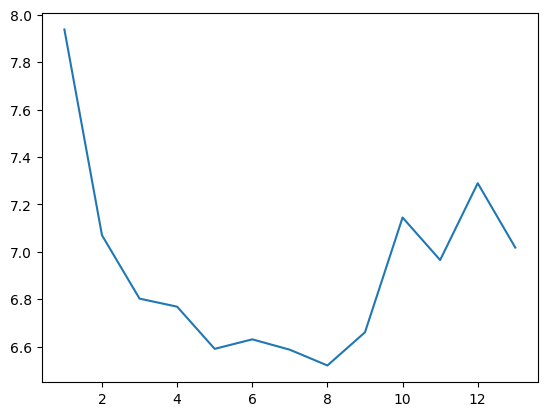

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl_gru) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_gru)
plt.show()

In [107]:
model_gru = keras.models.load_model('model_gru.keras')

In [108]:
# predicción con beam search
salidas_gru = beam_search(model_gru,num_beams=20,num_words=25,input="el aire caliente fulgia como", temp=0.5, mode="det")

0.5


In [109]:
# veamos las salidas
for d in salidas_gru:
  print(decode(d))

el aire caliente fulgia como untres de la
compañera 
el aire caliente fulgia como untres de la
compañía, 
el aire caliente fulgia como untres de la
compañera,
el aire caliente fulgia como untres de la
compañera.
el aire caliente fulgia como untres de la
compañía d
el aire caliente fulgia como untres de la
compañía. 
el aire caliente fulgia como una
muerto de las cerca
el aire caliente fulgia como una
muerto de las manos
el aire caliente fulgia como untres de la
compañía e
el aire caliente fulgia como untres de la
compañía c
el aire caliente fulgia como untres de la
compañía a
el aire caliente fulgia como untres de la
compañía y
el aire caliente fulgia como untres de la
compañada 
el aire caliente fulgia como untres de la
compañara 
el aire caliente fulgia como untres de la
compañía q
el aire caliente fulgia como untres de la
compañía p
el aire caliente fulgia como untres de la
compañía s
el aire caliente fulgia como una mujer contra en la c
el aire caliente fulgia como una mujer contra

### LSTM

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense


####
model_lstm = Sequential()
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(120, return_sequences=True, dropout=0.1)) #remove reccurent_dropount since it slows the training disabled GPU
model_lstm.add(Dense(vocab_size, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_13             │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 120)      │        90,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, None, 68)       │         8,228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,948 (386.52 KB)

 Trainable params: 98,948 (386.52 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
history_ppl_lstm = []
hist_lstm = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_lstm, name_model="model_lstm.keras")], batch_size=150)

Epoch 1/20
2923/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6298model_lstm.keras

 mean perplexity: 9.537123638501647 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - loss: 2.6293
Epoch 2/20
2927/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1631model_lstm.keras

 mean perplexity: 8.805992858855387 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 2.1631
Epoch 3/20
2924/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0720model_lstm.keras

 mean perplexity: 8.532348346416466 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 2.0719
Epoch 4/20
2925/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0108model_lstm.keras

 mean perplexity: 8.02657314492447 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 2.0108
Epoch 5/20
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9672model_lstm.keras

 mean perplexity: 7.7996597270456425 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 1.

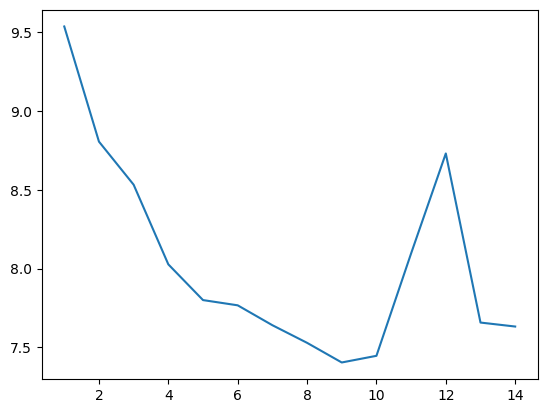

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl_lstm) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_lstm)
plt.show()

In [111]:
model_lstm = keras.models.load_model('model_lstm.keras')

In [112]:
# predicción con beam search
salidas_lstm = beam_search(model_lstm,num_beams=20,num_words=25,input="el aire caliente fulgia como", temp=0.5, mode="det")

0.5


In [113]:
# veamos las salidas
for d in salidas_lstm:
  print(decode(d))

el aire caliente fulgia como que los caucheros de los
el aire caliente fulgia como que los caucheros, para 
el aire caliente fulgia como que los compañeros de la
el aire caliente fulgia como que los caucheros con la
el aire caliente fulgia como que los compresas de la 
el aire caliente fulgia como que los caucheros de la 
el aire caliente fulgia como que nos compañeros de la
el aire caliente fulgia como que los compañeros, por 
el aire caliente fulgia como que los caucheros de las
el aire caliente fulgia como que los compresas de las
el aire caliente fulgia como que los caucheros de lar
el aire caliente fulgia como que los compañeros de lo
el aire caliente fulgia como que los compresas de los
el aire caliente fulgia como que los caucheros con lo
el aire caliente fulgia como que los caucheros de mi 
el aire caliente fulgia como que los caucheros de sus
el aire caliente fulgia como que nos compañeros de lo
el aire caliente fulgia como que los caucheros, de la
el aire caliente fulgia como

### Bidirectional GRU

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GRU, Bidirectional, Dense


####
model_gru_bidirectioal = Sequential()
model_gru_bidirectioal.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru_bidirectioal.add(Bidirectional(GRU(120, return_sequences=True, dropout=0.1))) #remove reccurent_dropount since it slows the training disabled GPU
model_gru_bidirectioal.add(Dense(vocab_size, activation='softmax'))
model_gru_bidirectioal.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_gru_bidirectioal.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 240)      │       136,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, None, 68)       │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,188 (598.39 KB)

 Trainable params: 153,188 (598.39 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
history_ppl_gru_bidirectional = []
hist_gru_bidirectional = model_gru_bidirectioal.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_gru_bidirectional, name_model="model_gru_bidirectional.keras")], batch_size=150)

Epoch 1/20
2925/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7259model_gru_bidirectional.keras

 mean perplexity: 9.894390237404826 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 69s 22ms/step - loss: 0.7253
Epoch 2/20
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1375model_gru_bidirectional.keras

 mean perplexity: 9.342555483263865 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 0.1375
Epoch 3/20
2927/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1142model_gru_bidirectional.keras

 mean perplexity: 8.810324923948096 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - loss: 0.1142
Epoch 4/20
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1031model_gru_bidirectional.keras

 mean perplexity: 8.526112291602383 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - loss: 0.1031
Epoch 5/20
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0958model_gru_bidirectional.keras

 mean perplexity: 8.323895287464776 

Sa

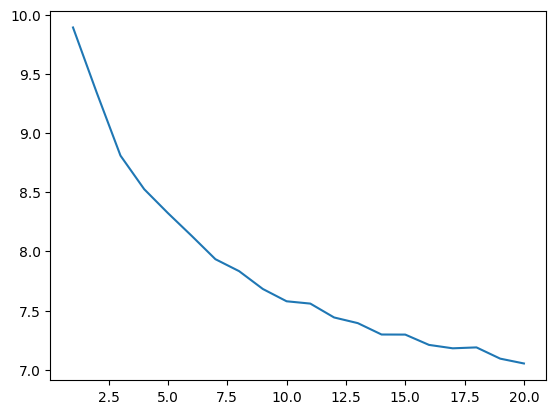

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl_gru_bidirectional) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_gru_bidirectional)
plt.show()

In [120]:
model_gru_bidirectional = keras.models.load_model('model_gru_bidirectional.keras')
salidas_bidirectional_gru = beam_search(model_gru_bidirectional,num_beams=20,num_words=25,input="el aire caliente fulgia como", temp=0.5, mode="det")
# veamos las salidas
for d in salidas_bidirectional_gru:
  print(decode(d))

0.5
el aire caliente fulgia como una tranca de las manos 
el aire caliente fulgia como una tranca de las manos.
el aire caliente fulgia como una tranca de los desest
el aire caliente fulgia como una tranca de los despon
el aire caliente fulgia como una tranca de las manos,
el aire caliente fulgia como una trancia de la conten
el aire caliente fulgia como una destración de las la
el aire caliente fulgia como una tranca de los descon
el aire caliente fulgia como una tranca de las manosa
el aire caliente fulgia como una trancia, en el conoc
el aire caliente fulgia como una destración de las ma
el aire caliente fulgia como una destración de la car
el aire caliente fulgia como una tranca de los desora
el aire caliente fulgia como una destración de la con
el aire caliente fulgia como una tranca de los desari
el aire caliente fulgia como una destración de las ce
el aire caliente fulgia como una tranca de los descom
el aire caliente fulgia como una tranca de los desesp
el aire caliente fulgia 

### Bidirectional Single RNN

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GRU, Bidirectional, Dense


####
model_rnn_bidirectioal = Sequential()
model_rnn_bidirectioal.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_rnn_bidirectioal.add(Bidirectional(SimpleRNN(200, return_sequences=True, dropout=0.1))) #remove reccurent_dropount since it slows the training disabled GPU
model_rnn_bidirectioal.add(Dense(vocab_size, activation='softmax'))
model_rnn_bidirectioal.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_rnn_bidirectioal.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_18             │ (None, None, 68)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, None, 400)      │       107,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, None, 68)       │        27,268 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,868 (526.83 KB)

 Trainable params: 134,868 (526.83 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
history_ppl_rnn_bidirectional = []
hist_rnn_bidirectional = model_rnn_bidirectioal.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_rnn_bidirectional, name_model="model_rnn_bidirectional.keras")], batch_size=150)

Epoch 1/20
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3893model_rnn_bidirectional.keras

 mean perplexity: 9.231399260996794 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 95s 29ms/step - loss: 0.3892
Epoch 2/20
2926/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1157model_rnn_bidirectional.keras

 mean perplexity: 8.491491919915045 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - loss: 0.1157
Epoch 3/20
2927/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1021model_rnn_bidirectional.keras

 mean perplexity: 8.206436756455188 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - loss: 0.1021
Epoch 4/20
2926/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0936model_rnn_bidirectional.keras

 mean perplexity: 7.746033699850282 

Saved new model!
2928/2928 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - loss: 0.0936
Epoch 5/20
2927/2928 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0872model_rnn_bidirectional.keras

 mean perplexity: 7.563907958643637 

Sa

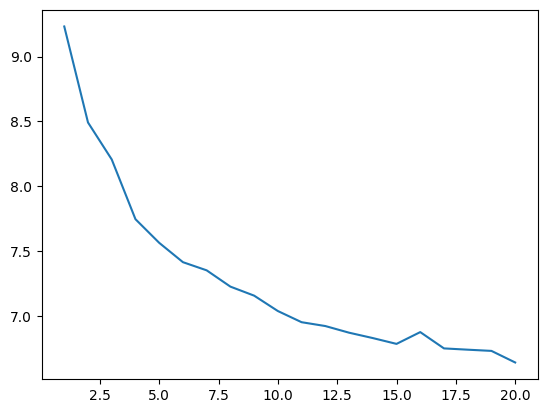

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl_rnn_bidirectional) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_rnn_bidirectional)
plt.show()

In [126]:
model_rnn_bidirectional = keras.models.load_model('model_rnn_bidirectional.keras')
salidas_bidirectional_gru = beam_search(model_rnn_bidirectional,num_beams=20,num_words=25,input="el aire caliente fulgia como", temp=0.5, mode="det")
# veamos las salidas
for d in salidas_bidirectional_gru:
  print(decode(d))

0.5
el aire caliente fulgia como para que la madona para 
el aire caliente fulgia como para que la madona de la
el aire caliente fulgia como para que la madona, con 
el aire caliente fulgia como para que la madona los p
el aire caliente fulgia como para que la madona con l
el aire caliente fulgia como para que la madona con e
el aire caliente fulgia como para que la madona los c
el aire caliente fulgia como para que la madona a la 
el aire caliente fulgia como para que la madona, para
el aire caliente fulgia como para que la madona los d
el aire caliente fulgia como para que la madana los p
el aire caliente fulgia como para que la madona con m
el aire caliente fulgia como para que la madona los a
el aire caliente fulgia como para que la madona por e
el aire caliente fulgia como para que la madona la ca
el aire caliente fulgia como para que la madona los b
el aire caliente fulgia como para que la madona, como
el aire caliente fulgia como para que la madona los m
el aire caliente fulgia 

### Conclusiones

Se realizó la prueba de 5 arquitecturas diferentes:

- Single RNN
- GRU
- LSTM
- BIDIRECTIONAL GRU
- BIDIRECTIONAL SINGLE RNN

Con los parámetros ajutados en:
- número de beams: 20
- número de words: 25
- temperatura: 0.5
- modo: determinista

Se hizo las pruebas en modo estocástico pero no terminó de entrenar y de ejecutar las arquitecturas mas complejas que sobrepasaban mas de 50k parámetros tales como LSTM y las BIDIRECTIONALS.

El corpus de prueba fue la Voráginey las sescuencias fueron:
- input: "el aire caliente fulgia como"
- target: "el aire caliente fulgia como lamina"


La métrica de perplejidad estuvo entre 5.5 a 7.5 para todas las arquitecturas y la predicción no alcanzó el resultado esperado. Se logró notar que la secuencia que mas se observavá en el corpus en este caso "Hombre", "madona" predominaban en las predicciones.

Se uso un optimizador de Adam pero el resultado estaba en en el mismo rango.